### Final Analysis
* The temperature vs latitude regressions predict that temperature rises as proximity to the equator increases.
* The humidity vs latitude scatter plot shows that humidity tends to be higher rather than lower.
* The wind speed vs latitude scatter plot shows that wind speed tends to be lower rather than higher.

In [1]:
# import dependencies
import gmaps
import requests
import json
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from citipy import citipy

In [2]:
# import api key
from api_keys import (wkey, gkey)

In [3]:
# import country code dictionary
from ISO3166 import ISO3166

In [4]:
# configure gmaps
gmaps.configure(api_key = gkey)

### Construct the List of Coordinates

In [5]:
# specify the lat/long ranges
latRange = (-90, 90)
lonRange = (-180, 180)

# create randomized lat/long lists
latList = np.random.uniform(latRange[0], latRange[1], size = 1500)
lonList = np.random.uniform(lonRange[0], lonRange[1], size = 1500)

# combine the lat/long lists into list
coordinates = zip(latList, lonList)

### Assemble the List of Cities

In [6]:
# initialize the list of city names
cityNames = []
countryCodes = []

# iterate through the list of coordinates
for coordinate in coordinates:
    city = citipy.nearest_city(coordinate[0], coordinate[1])
    cityName = city.city_name
    countryCode = city.country_code
    
    # add the new city to cityNames if it isn't already there
    if cityName not in cityNames:
        cityNames.append(cityName)
        countryCodes.append(countryCode)

print(f"A total of {len(cityNames)} cities have been retrieved.")

A total of 597 cities have been retrieved.


### Retrieve the Weather Data

In [7]:
# specify the unit types
units = "imperial"

# initialize the lists
temperature_Data = []
humidity_Data = []
cloudiness_Data = []
windSpeed_Data = []
latitude_Data = []
longitude_Data = []

# create the country name variable
countryName = ""

# iterate through the retrieved cities (limited during development)
#for i in range(20):
for i in range(len(cityNames)):
    
    # assign the country name
    try:
        countryName = ISO3166[countryCodes[i].upper()]
    except KeyError:
        countryName = {countryCodes[i]}
        print("Country code did not exist in the provided dictionary.")
    
    # construct the request URL with an f-string
    if units == "standard":
        url = f"https://api.openweathermap.org/data/2.5/weather?q={cityNames[i]},{countryCodes[i]}&appid={wkey}"
    else:
        url = f"https://api.openweathermap.org/data/2.5/weather?q={cityNames[i]},{countryCodes[i]}&appid={wkey}&units={units}"
    
    # perform the api request
    response_json = requests.get(url).json()
    
    try:
        # store the relevant output in their respective lists
        temperature_Data.append(response_json["main"]["temp_max"])
        humidity_Data.append(response_json["main"]["humidity"])
        cloudiness_Data.append(response_json["clouds"]["all"])
        windSpeed_Data.append(response_json["wind"]["speed"])
        latitude_Data.append(response_json["coord"]["lat"])
        longitude_Data.append(response_json["coord"]["lon"])
        
        # contribute to the print log
        print(f"City #{i}: {cityNames[i]}, {countryName}")
        
    except KeyError:
        print(f"City #{i}: key did not exist in the JSON object (City = {cityNames[i]}).")
    
    # constrain the request rate to ~57/minute
    time.sleep(1.05)

print(f"A total of {len(temperature_Data)} cities have been successfully analyzed.")

City #0: hilo, United States of America
City #1: businga, Congo
City #2: avarua, Cook Iislands
City #3: grand gaube, Mauritius
City #4: quatre cocos, Mauritius
City #5: muzaffarabad, Pakistan
City #6: mogocha, Russian Federation
City #7: atuona, French Polynesia
City #8: cherskiy, Russian Federation
City #9: arraial do cabo, Brazil
City #10: flinders, Australia
City #11: hollister, United States of America
City #12: panguna, Papua New Guinea
City #13: sept-iles, Canada
City #14: kapaa, United States of America
City #15: guerrero negro, Mexico
City #16: georgetown, St. Helena
City #17: bluff, New Zealand
City #18: albany, Australia
City #19: san cristobal, Ecuador
City #20: pecos, United States of America
City #21: smithers, Canada
City #22: arlit, Niger
City #23: sitka, United States of America
City #24: waingapu, Indonesia
City #25: torbay, Canada
City #26: key did not exist in the JSON object (City = attawapiskat).
City #27: key did not exist in the JSON object (City = mataura).
City

City #220: ondangwa, Namibia
City #221: batagay-alyta, Russian Federation
City #222: lowestoft, United Kingdom (Great Britain)
City #223: ambilobe, Madagascar
City #224: ngunguru, New Zealand
City #225: kirakira, Solomon Islands
City #226: port hardy, Canada
City #227: sabang, Indonesia
City #228: plastun, Russian Federation
City #229: kuytun, Russian Federation
City #230: valle de allende, Mexico
City #231: bagan, Russian Federation
City #232: tres lagoas, Brazil
City #233: kijang, Indonesia
City #234: malm, Norway
City #235: antigonish, Canada
City #236: pevek, Russian Federation
City #237: parainen, Finland
City #238: kaeo, New Zealand
City #239: esperance, Australia
City #240: vallenar, Chile
City #241: beloha, Madagascar
City #242: cayenne, French Guiana
City #243: bilma, Niger
City #244: nobeoka, Japan
City #245: key did not exist in the JSON object (City = abu samrah).
City #246: sur, Oman
City #247: ninghai, China
City #248: itupiranga, Brazil
City #249: key did not exist in th

City #449: ahipara, New Zealand
City #450: puerto escondido, Mexico
City #451: garissa, Kenya
City #452: key did not exist in the JSON object (City = kralendijk).
City #453: clarence town, Bahama
City #454: hambantota, Sri Lanka
City #455: plyussa, Russian Federation
City #456: sisimiut, Greenland
City #457: chama, Zambia
City #458: sungaipenuh, Indonesia
City #459: margate, South Africa
City #460: anadyr, Russian Federation
City #461: balykshi, Kazakhstan
City #462: evensk, Russian Federation
City #463: stromness, United Kingdom (Great Britain)
City #464: harper, Liberia
City #465: sayaxche, Guatemala
City #466: shaunavon, Canada
City #467: along, India
City #468: bhusawal, India
City #469: katherine, Australia
City #470: rio grande, Brazil
City #471: xihe, China
City #472: skjervoy, Norway
City #473: kamenka, Russian Federation
City #474: key did not exist in the JSON object (City = ituni).
City #475: taksimo, Russian Federation
City #476: faanui, French Polynesia
City #477: khudumel

### Display City Locations to Confirm Algorithm Accuracy

In [21]:
# create the locations DataFrame
locations = pd.DataFrame({
                    "Lat": latitude_Data,
                    "Lng": longitude_Data})

# preview the DataFrame structure
locations.head()

,Lat,Lng
0,19.7297,-155.0900
1,3.3333,20.8833
2,-21.2078,-159.7750
3,-20.0064,57.6608
4,-20.2078,57.7625


In [9]:
# initialize the map figure
mapFig = gmaps.figure()

# define the city layer
city_layer = gmaps.symbol_layer(
                locations,
                fill_color = "rgba(0, 150, 0, 0.4)",
                stroke_color = "rgba(0, 0, 150, 0.4)",
                scale = 2)

# add the city layer to the map
mapFig.add_layer(city_layer)

# display the map
mapFig

Figure(layout=FigureLayout(height='420px'))

### Display the Weather Data

In [10]:
# specify the plot specific variables
markers = "o"
size = 15
color = "red"
edgeColors = "black"
regressionColor = "blue"
lineStyle = "-."

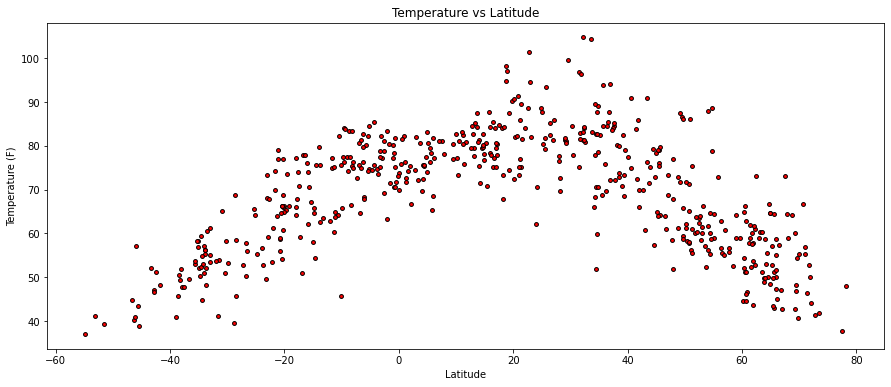

In [11]:
# specify the plot size
plt.figure(figsize = (15, 6))

# construct the plot
plt.scatter(latitude_Data,
            temperature_Data,
            marker = markers, 
            s = size,
            c = color,
            edgecolors = edgeColors)

# set up the labels and title
plt.xlabel("Latitude")
plt.ylabel("Temperature (F)")
plt.title("Temperature vs Latitude")

# save the plot
plt.savefig("Images/Temperature vs Latitude.png")

# show the plot
plt.show()

###### Observations
This scatter plot displays the relationship between a city's latitudinal position and its maximum temperature. It shows a general trend of temperature to be higher at the equator than at the upper and lower latitudes.

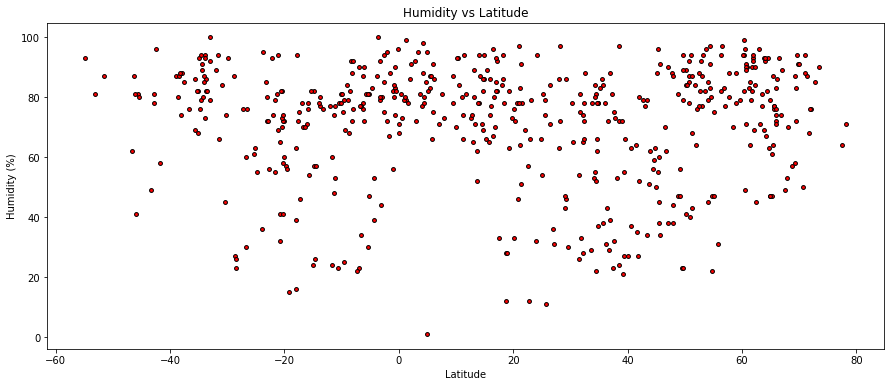

In [12]:
# specify the plot size
plt.figure(figsize = (15, 6))

# construct the plot
plt.scatter(latitude_Data,
            humidity_Data,
            marker = markers, 
            s = size,
            c = color,
            edgecolors = edgeColors)

# set up the labels and title
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title("Humidity vs Latitude")

# save the plot
plt.savefig("Images/Humidity vs Latitude.png")

# show the plot
plt.show()

###### Observations
This scatter plot displays the relationship between a city's latitudinal position and its current humidity. There does not appear to to be a correlation between a city's latitude and its humidity.

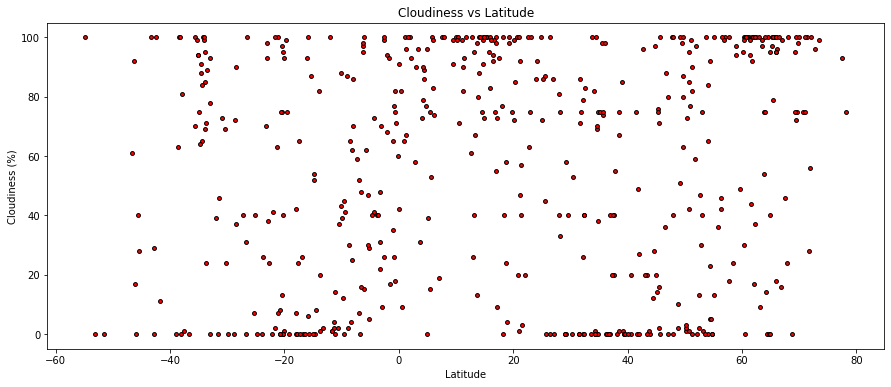

In [13]:
# specify the plot size
plt.figure(figsize = (15, 6))

# construct the plot
plt.scatter(latitude_Data,
            cloudiness_Data,
            marker = markers, 
            s = size,
            c = color,
            edgecolors = edgeColors)

# set up the labels and title
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title("Cloudiness vs Latitude")

# save the plot
plt.savefig("Images/Cloudiness vs Latitude.png")

# show the plot
plt.show()

###### Observations
This scatter plot displays the relationship between a city's latitudinal position and its current cloudiness. There doesn't appear to be a trend evident from this plot.

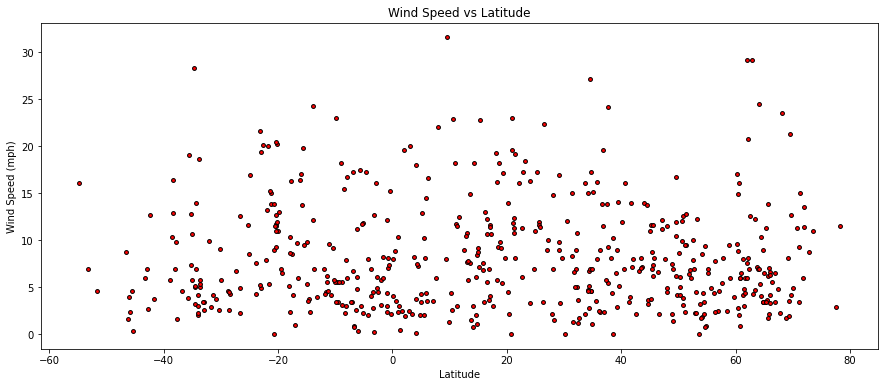

In [14]:
# specify the plot size
plt.figure(figsize = (15, 6))

# construct the plot
plt.scatter(latitude_Data,
            windSpeed_Data,
            marker = markers, 
            s = size,
            c = color,
            edgecolors = edgeColors)

# set up the labels and title
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title("Wind Speed vs Latitude")

# save the plot
plt.savefig("Images/Wind Speed vs Latitude.png")

# show the plot
plt.show()

###### Observations
This scatter plot displays the relationship between a city's latitudinal position and its current wind speed. This plot does not show an evident plot aside from the tendency for wind speeds to be lower across the board.

### Combine Lists into DataFrame

In [24]:
# combine the lists into a DataFrame to work better in a regression
weather_df = pd.DataFrame({
                        "Latitude": latitude_Data,
                        "Longitude": longitude_Data,
                        "Max Temperature (F)": temperature_Data,
                        "Humidity (%)": humidity_Data,
                        "Cloudiness (%)": cloudiness_Data,
                        "Wind Speed (mph)": windSpeed_Data})

# save the DataFrame to file
weather_df.to_csv("Output/city_weather_data.csv", index = False)

# preview the DataFrame
weather_df.head()

,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,19.7297,-155.0900,90.28,73,75,8.05
1,3.3333,20.8833,72.21,95,96,2.10
2,-21.2078,-159.7750,77.05,69,7,14.97
3,-20.0064,57.6608,66.38,72,93,11.01
4,-20.2078,57.7625,66.09,72,95,20.27


In [29]:
# create Northern hemisphere DataFrame
northern_df = weather_df.loc[weather_df["Latitude"] >= 0, :].reset_index(drop = True)

# preview the Northern hemisphere DataFrame
northern_df.head()

,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,19.7297,-155.0900,90.28,73,75,8.05
1,3.3333,20.8833,72.21,95,96,2.10
2,34.3700,73.4711,77.94,84,1,2.80
3,53.7333,119.7667,52.43,96,100,3.15
4,68.7500,161.3000,64.20,57,0,1.66


In [30]:
# create Southern hemisphere DataFrame
southern_df = weather_df.loc[weather_df["Latitude"] < 0, :].reset_index(drop = True)

# preview the Southern hemisphere DataFrame
southern_df.head()

,Latitude,Longitude,Max Temperature (F),Humidity (%),Cloudiness (%),Wind Speed (mph)
0,-21.2078,-159.7750,77.05,69,7,14.97
1,-20.0064,57.6608,66.38,72,93,11.01
2,-20.2078,57.7625,66.09,72,95,20.27
3,-9.8000,-139.0333,77.40,75,12,23.00
4,-22.9661,-42.0278,68.02,80,98,19.39


In [31]:
# calculate the maximum and minimum y values
max_temperature = max(weather_df["Max Temperature (F)"])
min_temperature = min(weather_df["Max Temperature (F)"])
max_humidity = max(weather_df["Humidity (%)"])
min_humidity = min(weather_df["Humidity (%)"])
max_cloudiness = max(weather_df["Cloudiness (%)"])
min_cloudiness = min(weather_df["Cloudiness (%)"])
max_windspeed = max(weather_df["Wind Speed (mph)"])
min_windspeed = min(weather_df["Wind Speed (mph)"])

# define the margin factor
mFactor = 0.05

# add margins to the max/min values
max_temperature = max_temperature + mFactor * max_temperature
min_temperature = min_temperature - mFactor * min_temperature
max_humidity = max_humidity + mFactor * max_humidity
min_humidity = min_humidity - mFactor * min_humidity
max_cloudiness = max_cloudiness + mFactor * max_cloudiness
min_cloudiness = min_cloudiness - mFactor * min_cloudiness
max_windspeed = max_windspeed + mFactor * max_windspeed
min_windspeed = min_windspeed - mFactor * min_windspeed

In [32]:
# extract the x series for use in the linear regressions
x_values_northern = northern_df["Latitude"]
x_values_southern = southern_df["Latitude"]

# extract the y series for use in the linear regressions
y_values_northern_temperature = northern_df["Max Temperature (F)"]
y_values_northern_humidity = northern_df["Humidity (%)"]
y_values_northern_cloudiness = northern_df["Cloudiness (%)"]
y_values_northern_windspeed = northern_df["Wind Speed (mph)"]
y_values_southern_temperature = southern_df["Max Temperature (F)"]
y_values_southern_humidity = southern_df["Humidity (%)"]
y_values_southern_cloudiness = southern_df["Cloudiness (%)"]
y_values_southern_windspeed = southern_df["Wind Speed (mph)"]

### Perform the Linear Regressions (Temperature)

Southern Latitude =>	correlation = 0.84	r2 = 0.70
Northern Latitude =>	correlation = -0.70	r2 = 0.49


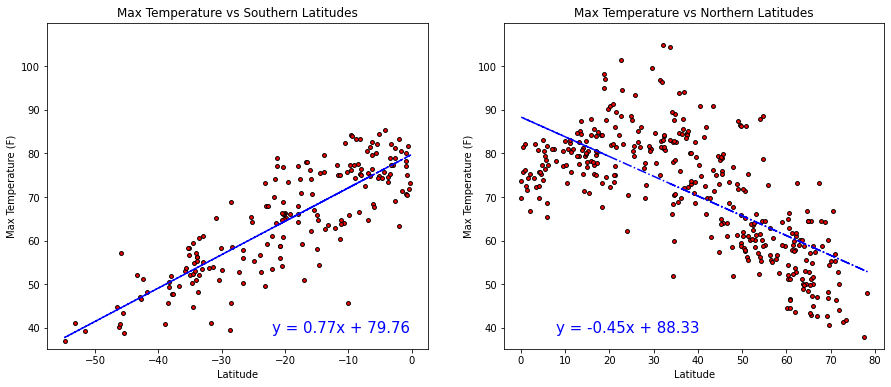

In [36]:
# define the line equation's position variables (% of axis)
x_northern_position = 0.10
x_southern_position = 0.60
y_position = 0.05

# reuse variables for easier reassignment
y_values_northern = y_values_northern_temperature
y_values_southern = y_values_southern_temperature
y_max = max_temperature
y_min = min_temperature
category = "Max Temperature"
categoryUnits = "(F)"

# calculate the northern regression
(slopeN, interceptN, rvalueN, pvalueN, stderrN) = stats.linregress(x_values_northern, y_values_northern)
regress_valuesN = x_values_northern * slopeN + interceptN
line_equationN = f"y = {slopeN:,.2f}x + {interceptN:,.2f}"

# calculate the southern regression
(slopeS, interceptS, rvalueS, pvalueS, stderrS) = stats.linregress(x_values_southern, y_values_southern)
regress_valuesS = x_values_southern * slopeS + interceptS
line_equationS = f"y = {slopeS:,.2f}x + {interceptS:,.2f}"

# calculate the northern correlation factor
northern_correlation = stats.pearsonr(x_values_northern, y_values_northern)[0]
southern_correlation = stats.pearsonr(x_values_southern, y_values_southern)[0]

# print the correlation factors
print(f"Southern Latitude =>\tcorrelation = {southern_correlation:,.2f}\tr2 = {rvalueS**2:,.2f}")
print(f"Northern Latitude =>\tcorrelation = {northern_correlation:,.2f}\tr2 = {rvalueN**2:,.2f}")

# specify the subplots
fig0, (ax0, ax1) = plt.subplots(1, 2, figsize = (15, 6))

# construct the plots
ax0.scatter(x_values_southern,
                y_values_southern,
                marker = markers, 
                s = size,
                c = color,
                edgecolors = edgeColors)
ax0.plot(x_values_southern,
                regress_valuesS,
                color = regressionColor,
                linestyle = lineStyle)
ax1.scatter(x_values_northern,
                y_values_northern,
                marker = markers, 
                s = size,
                c = color,
                edgecolors = edgeColors)
ax1.plot(x_values_northern,
                regress_valuesN,
                color = regressionColor,
                linestyle = lineStyle)

# calculate the position for the line equation
x_position_northern = min(x_values_northern) + (max(x_values_northern) - min(x_values_northern)) * x_northern_position
x_position_southern = min(x_values_southern) + (max(x_values_southern) - min(x_values_southern)) * x_southern_position
y_position = y_min + (y_max - y_min) * y_position

# add the line equation
ax0.annotate(line_equationS, (x_position_southern, y_position), fontsize = 15, color = regressionColor)
ax1.annotate(line_equationN, (x_position_northern, y_position), fontsize = 15, color = regressionColor)

# set up y axis limits
ax0.set_ylim(y_min, y_max)
ax1.set_ylim(y_min, y_max)

# set up the labels and title
ax0.set_xlabel("Latitude")
ax0.set_ylabel(f"{category} {categoryUnits}")
ax0.set_title(f"{category} vs Southern Latitudes")
ax1.set_xlabel("Latitude")
ax1.set_ylabel(f"{category} {categoryUnits}")
ax1.set_title(f"{category} vs Northern Latitudes")

# save the plot
plt.savefig(f"Images/{category} vs Latitudes - Regression.png")

# show the plot
plt.show()

###### Observations
This pair of linear regressions shows the linear regression fit to the previous Max Temperature vs Latitude scatter plot. The previous plot has been split into Southern and Northern hemispheres for these linear regressions. As can be seen, there is strong correlation for both hemispheres that temperature increases with proximity to the equator.

### Perform the Linear Regressions (Humidity)

Southern Latitude =>	correlation = -0.11	r2 = 0.01
Northern Latitude =>	correlation = 0.02	r2 = 0.00


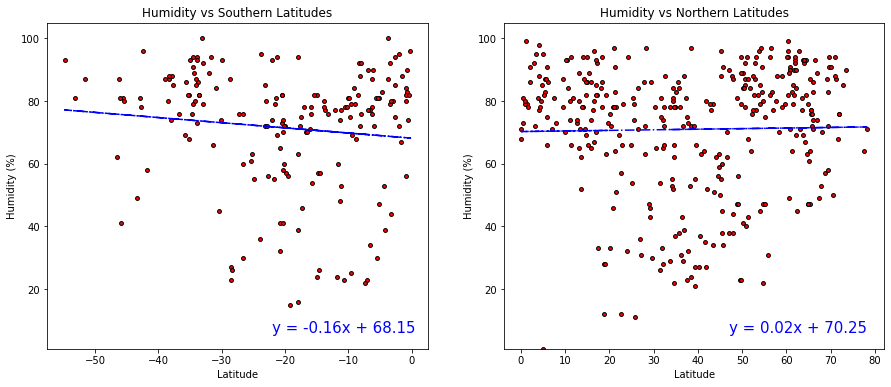

In [18]:
# define the line equation's position variables (% of axis)
x_northern_position = 0.60
x_southern_position = 0.60
y_position = 0.05

# reuse variables for easier reassignment
y_values_northern = y_values_northern_humidity
y_values_southern = y_values_southern_humidity
y_max = max_humidity
y_min = min_humidity
category = "Humidity"
categoryUnits = "(%)"

# calculate the northern regression
(slopeN, interceptN, rvalueN, pvalueN, stderrN) = stats.linregress(x_values_northern, y_values_northern)
regress_valuesN = x_values_northern * slopeN + interceptN
line_equationN = f"y = {slopeN:,.2f}x + {interceptN:,.2f}"

# calculate the southern regression
(slopeS, interceptS, rvalueS, pvalueS, stderrS) = stats.linregress(x_values_southern, y_values_southern)
regress_valuesS = x_values_southern * slopeS + interceptS
line_equationS = f"y = {slopeS:,.2f}x + {interceptS:,.2f}"

# calculate the northern correlation factor
northern_correlation = stats.pearsonr(x_values_northern, y_values_northern)[0]
southern_correlation = stats.pearsonr(x_values_southern, y_values_southern)[0]

# print the correlation factors
print(f"Southern Latitude =>\tcorrelation = {southern_correlation:,.2f}\tr2 = {rvalueS**2:,.2f}")
print(f"Northern Latitude =>\tcorrelation = {northern_correlation:,.2f}\tr2 = {rvalueN**2:,.2f}")

# specify the subplots
fig0, (ax0, ax1) = plt.subplots(1, 2, figsize = (15, 6))

# construct the plots
ax0.scatter(x_values_southern,
                y_values_southern,
                marker = markers, 
                s = size,
                c = color,
                edgecolors = edgeColors)
ax0.plot(x_values_southern,
                regress_valuesS,
                color = regressionColor,
                linestyle = lineStyle)
ax1.scatter(x_values_northern,
                y_values_northern,
                marker = markers, 
                s = size,
                c = color,
                edgecolors = edgeColors)
ax1.plot(x_values_northern,
                regress_valuesN,
                color = regressionColor,
                linestyle = lineStyle)

# calculate the position for the line equation
x_position_northern = min(x_values_northern) + (max(x_values_northern) - min(x_values_northern)) * x_northern_position
x_position_southern = min(x_values_southern) + (max(x_values_southern) - min(x_values_southern)) * x_southern_position
y_position = y_min + (y_max - y_min) * y_position

# add the line equation
ax0.annotate(line_equationS, (x_position_southern, y_position), fontsize = 15, color = regressionColor)
ax1.annotate(line_equationN, (x_position_northern, y_position), fontsize = 15, color = regressionColor)

# set up y axis limits
ax0.set_ylim(y_min, y_max)
ax1.set_ylim(y_min, y_max)

# set up the labels and title
ax0.set_xlabel("Latitude")
ax0.set_ylabel(f"{category} {categoryUnits}")
ax0.set_title(f"{category} vs Southern Latitudes")
ax1.set_xlabel("Latitude")
ax1.set_ylabel(f"{category} {categoryUnits}")
ax1.set_title(f"{category} vs Northern Latitudes")

# save the plot
plt.savefig(f"Images/{category} vs Latitudes - Regression.png")

# show the plot
plt.show()

###### Observations
This pair of linear regressions shows the linear regression fit to the previous Humidity vs Latitude scatter plot. The previous plot has been split into Southern and Northern hemispheres for these linear regressions. As can be seen, there is very weak correlation for both hemispheres that humidity changes with proximity to the equator.

### Perform the Linear Regressions (Cloudiness)

Southern Latitude =>	correlation = -0.08	r2 = 0.01
Northern Latitude =>	correlation = -0.04	r2 = 0.00


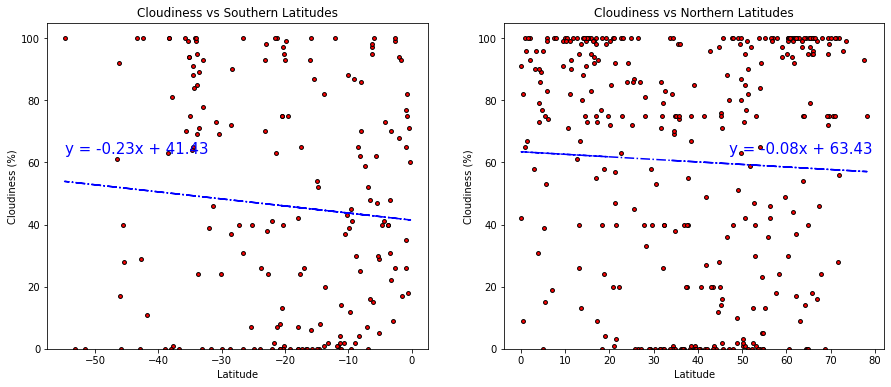

In [19]:
# define the line equation's position variables (% of axis)
x_northern_position = 0.60
x_southern_position = 0.00
y_position = 0.60

# reuse variables for easier reassignment
y_values_northern = y_values_northern_cloudiness
y_values_southern = y_values_southern_cloudiness
y_max = max_cloudiness
y_min = min_cloudiness
category = "Cloudiness"
categoryUnits = "(%)"

# calculate the northern regression
(slopeN, interceptN, rvalueN, pvalueN, stderrN) = stats.linregress(x_values_northern, y_values_northern)
regress_valuesN = x_values_northern * slopeN + interceptN
line_equationN = f"y = {slopeN:,.2f}x + {interceptN:,.2f}"

# calculate the southern regression
(slopeS, interceptS, rvalueS, pvalueS, stderrS) = stats.linregress(x_values_southern, y_values_southern)
regress_valuesS = x_values_southern * slopeS + interceptS
line_equationS = f"y = {slopeS:,.2f}x + {interceptS:,.2f}"

# calculate the northern correlation factor
northern_correlation = stats.pearsonr(x_values_northern, y_values_northern)[0]
southern_correlation = stats.pearsonr(x_values_southern, y_values_southern)[0]

# print the correlation factors
print(f"Southern Latitude =>\tcorrelation = {southern_correlation:,.2f}\tr2 = {rvalueS**2:,.2f}")
print(f"Northern Latitude =>\tcorrelation = {northern_correlation:,.2f}\tr2 = {rvalueN**2:,.2f}")

# specify the subplots
fig0, (ax0, ax1) = plt.subplots(1, 2, figsize = (15, 6))

# construct the plots
ax0.scatter(x_values_southern,
                y_values_southern,
                marker = markers, 
                s = size,
                c = color,
                edgecolors = edgeColors)
ax0.plot(x_values_southern,
                regress_valuesS,
                color = regressionColor,
                linestyle = lineStyle)
ax1.scatter(x_values_northern,
                y_values_northern,
                marker = markers, 
                s = size,
                c = color,
                edgecolors = edgeColors)
ax1.plot(x_values_northern,
                regress_valuesN,
                color = regressionColor,
                linestyle = lineStyle)

# calculate the position for the line equation
x_position_northern = min(x_values_northern) + (max(x_values_northern) - min(x_values_northern)) * x_northern_position
x_position_southern = min(x_values_southern) + (max(x_values_southern) - min(x_values_southern)) * x_southern_position
y_position = y_min + (y_max - y_min) * y_position

# add the line equation
ax0.annotate(line_equationS, (x_position_southern, y_position), fontsize = 15, color = regressionColor)
ax1.annotate(line_equationN, (x_position_northern, y_position), fontsize = 15, color = regressionColor)

# set up y axis limits
ax0.set_ylim(y_min, y_max)
ax1.set_ylim(y_min, y_max)

# set up the labels and title
ax0.set_xlabel("Latitude")
ax0.set_ylabel(f"{category} {categoryUnits}")
ax0.set_title(f"{category} vs Southern Latitudes")
ax1.set_xlabel("Latitude")
ax1.set_ylabel(f"{category} {categoryUnits}")
ax1.set_title(f"{category} vs Northern Latitudes")

# save the plot
plt.savefig(f"Images/{category} vs Latitudes - Regression.png")

# show the plot
plt.show()

###### Observations
This pair of linear regressions shows the linear regression fit to the previous Cloudiness vs Latitude scatter plot. The previous plot has been split into Southern and Northern hemispheres for these linear regressions. As can be seen, there is very weak correlation for both hemispheres that cloudiness changes with proximity to the equator.

### Perform the Linear Regressions (Wind Speed)

Southern Latitude =>	correlation = -0.00	r2 = 0.00
Northern Latitude =>	correlation = -0.10	r2 = 0.01


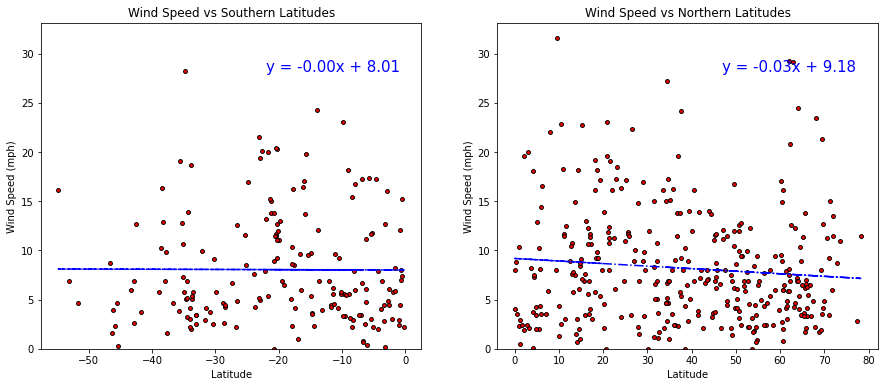

In [20]:
# define the line equation's position variables (% of axis)
x_northern_position = 0.60
x_southern_position = 0.60
y_position = 0.85

# reuse variables for easier reassignment
y_values_northern = y_values_northern_windspeed
y_values_southern = y_values_southern_windspeed
y_max = max_windspeed
y_min = min_windspeed
category = "Wind Speed"
categoryUnits = "(mph)"

# calculate the northern regression
(slopeN, interceptN, rvalueN, pvalueN, stderrN) = stats.linregress(x_values_northern, y_values_northern)
regress_valuesN = x_values_northern * slopeN + interceptN
line_equationN = f"y = {slopeN:,.2f}x + {interceptN:,.2f}"

# calculate the southern regression
(slopeS, interceptS, rvalueS, pvalueS, stderrS) = stats.linregress(x_values_southern, y_values_southern)
regress_valuesS = x_values_southern * slopeS + interceptS
line_equationS = f"y = {slopeS:,.2f}x + {interceptS:,.2f}"

# calculate the northern correlation factor
northern_correlation = stats.pearsonr(x_values_northern, y_values_northern)[0]
southern_correlation = stats.pearsonr(x_values_southern, y_values_southern)[0]

# print the correlation factors
print(f"Southern Latitude =>\tcorrelation = {southern_correlation:,.2f}\tr2 = {rvalueS**2:,.2f}")
print(f"Northern Latitude =>\tcorrelation = {northern_correlation:,.2f}\tr2 = {rvalueN**2:,.2f}")

# specify the subplots
fig0, (ax0, ax1) = plt.subplots(1, 2, figsize = (15, 6))

# construct the plots
ax0.scatter(x_values_southern,
                y_values_southern,
                marker = markers, 
                s = size,
                c = color,
                edgecolors = edgeColors)
ax0.plot(x_values_southern,
                regress_valuesS,
                color = regressionColor,
                linestyle = lineStyle)
ax1.scatter(x_values_northern,
                y_values_northern,
                marker = markers, 
                s = size,
                c = color,
                edgecolors = edgeColors)
ax1.plot(x_values_northern,
                regress_valuesN,
                color = regressionColor,
                linestyle = lineStyle)

# calculate the position for the line equation
x_position_northern = min(x_values_northern) + (max(x_values_northern) - min(x_values_northern)) * x_northern_position
x_position_southern = min(x_values_southern) + (max(x_values_southern) - min(x_values_southern)) * x_southern_position
y_position = y_min + (y_max - y_min) * y_position

# add the line equation
ax0.annotate(line_equationS, (x_position_southern, y_position), fontsize = 15, color = regressionColor)
ax1.annotate(line_equationN, (x_position_northern, y_position), fontsize = 15, color = regressionColor)

# set up y axis limits
ax0.set_ylim(y_min, y_max)
ax1.set_ylim(y_min, y_max)

# set up the labels and title
ax0.set_xlabel("Latitude")
ax0.set_ylabel(f"{category} {categoryUnits}")
ax0.set_title(f"{category} vs Southern Latitudes")
ax1.set_xlabel("Latitude")
ax1.set_ylabel(f"{category} {categoryUnits}")
ax1.set_title(f"{category} vs Northern Latitudes")

# save the plot
plt.savefig(f"Images/{category} vs Latitudes - Regression.png")

# show the plot
plt.show()

###### Observations
This pair of linear regressions shows the linear regression fit to the previous Wind Speed vs Latitude scatter plot. The previous plot has been split into Southern and Northern hemispheres for these linear regressions. As can be seen, there is very weak correlation for both hemispheres that wind speed changes with proximity to the equator.